In [1]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# import MAGI-X packages
from scripts.magix.dynamic import nnModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

In [2]:
climate = pd.read_csv("data/DailyDelhiClimate.csv")
climate.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


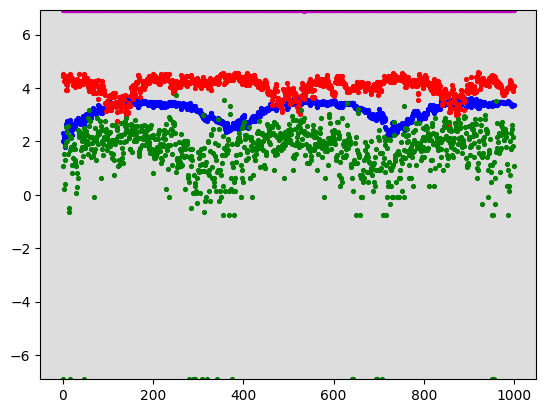

In [3]:
tmax = 1000 # consider only first 1000 data points for now
tdata = climate.index.to_numpy()[:tmax] # time
xdata = climate.iloc[:tmax,1:].to_numpy() # component values
xdata = np.log(xdata + 1e-3) # train it in log
no_comp = xdata.shape[1] # number of components

# visualize data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.scatter(tdata, xdata[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata),np.max(xdata))
plt.show()

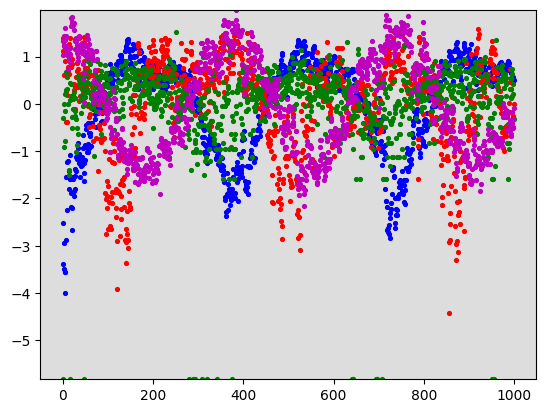

In [4]:
# standardization
xdata = (xdata - np.mean(xdata, axis=0))/np.std(xdata, axis=0) 

# visualize data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.scatter(tdata, xdata[:,i], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata),np.max(xdata))
plt.show()

In [5]:
# observation
tmax_train = 500
obs = [] # set random seed for noise
for i in range(no_comp):
    tobs = tdata[:tmax_train].copy()
    yobs = xdata[:tmax_train,i].copy()
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

In [6]:
# MAP
seed = 188714368 # random seed
torch.manual_seed(seed)
# define neural network dynamic
magix_node = [no_comp,2048,no_comp]
fOde = nnModule(magix_node, dp=0.25) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=251,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=5000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=True, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

/home/chuang397/.venv/lib64/python3.8/site-packages/linear_operator/utils/sparse.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


1/5000 iteration: 18.220999
1000/5000 iteration: 6.777085
2000/5000 iteration: 6.361126
3000/5000 iteration: 6.170760
4000/5000 iteration: 6.025059
5000/5000 iteration: 5.898185
run time: 336.46 seconds


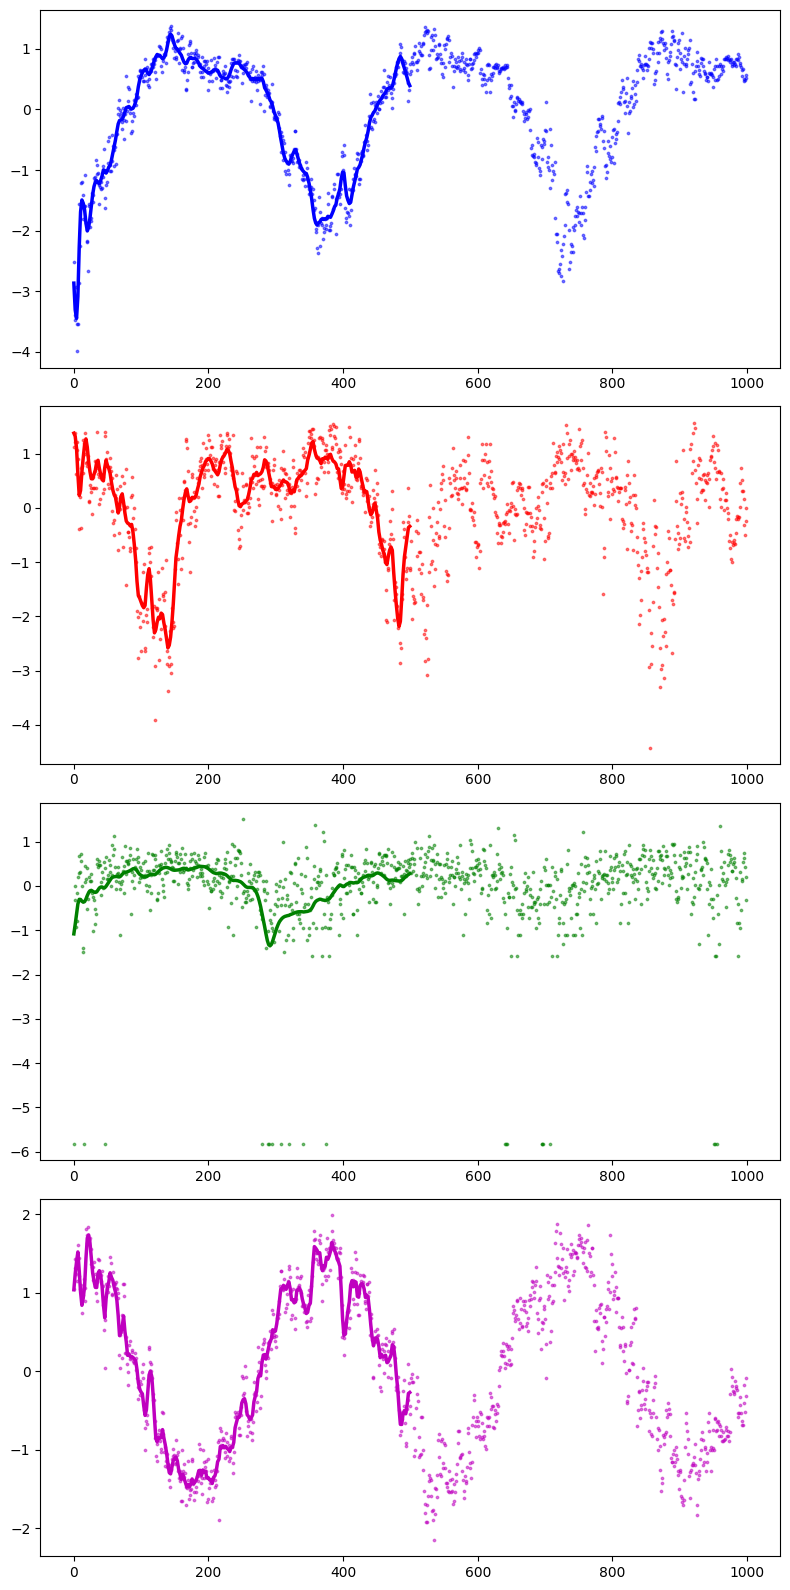

In [7]:
# inferred 
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(tinfer, xinfer[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_ylim(np.min(xdata[:,i]),np.max(xdata[:,i]))
fig.tight_layout()
plt.show()

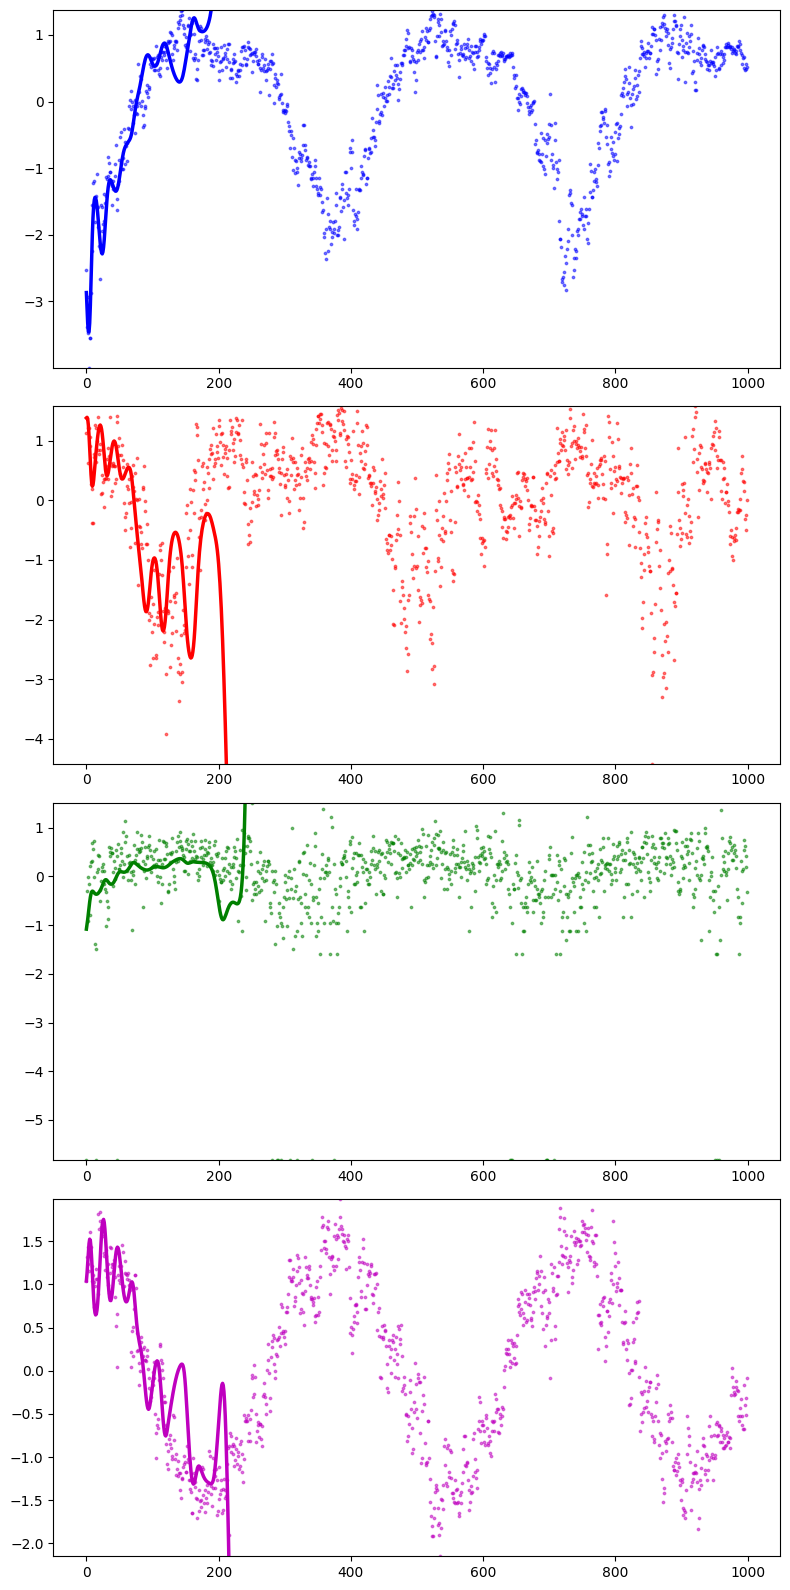

In [8]:
# reconstruction 
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(trecon, xrecon[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i]),np.max(xdata[:,i]))
fig.tight_layout()
plt.show()